In [2]:
import pandas as pd

In [3]:
import os
from os import listdir, system

# Get the current working directory
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

print("Parent Directory:", parent_dir)

Parent Directory: /gpfs/fs1/home/j/jparkin/wongkoji/PathwayCompleteness


In [4]:
def clean_ec_data(ec_number):
    """cleans ec data"""
    if not ec_number:
        return "None"
    if '-' in ec_number:
        return "None"
    # TODO: split these
    elif ';' in ec_number:
        return "None"
    else:
        return ec_number

In [5]:
deepec_dict = {}
deepec_dir = "/scratch/j/jparkin/wongkoji/deepec_outputs/"
entries = listdir(deepec_dir)
all_ec_df = pd.DataFrame()

for entry in entries:
    deepec_file = f"{deepec_dir}{entry}/DeepECv2_result.txt"
    deepec_df = pd.read_csv(deepec_file, sep='\t')
    # Drop any unannotated reads
    deepec_df = deepec_df[deepec_df['prediction'] != 'None']
    # clean up formats of EC data
    deepec_df['prediction'] = deepec_df['prediction'].apply(clean_ec_data)
    # format ECs with lowercase for KEGG API
    deepec_df['prediction'] = deepec_df['prediction'].apply(str.lower)
    key = entry.replace("deepEC_", "")
    deepec_dict[key] = deepec_df
entries = [s.replace("deepEC_", "") for s in entries]
deepec_dict

{'53408':                                          sequence_ID   prediction
 5         lcl|NZ_CP014158.1_cds_WP_043313934.1_4-4/1   ec:5.6.2.2
 6         lcl|NZ_CP014158.1_cds_WP_070065483.1_7-4/1   ec:2.7.7.6
 11       lcl|NZ_CP014158.1_cds_WP_043313912.1_24-4/1  ec:3.5.4.44
 14       lcl|NZ_CP014158.1_cds_WP_061560279.1_29-4/1  ec:2.6.1.76
 20       lcl|NZ_CP014158.1_cds_WP_061560283.1_37-4/1  ec:2.7.7.87
 ...                                              ...          ...
 21879  lcl|NZ_CP141948.1_cds_WP_043316086.1_6119-4/1   ec:2.7.7.7
 21881  lcl|NZ_CP141948.1_cds_WP_324710156.1_6121-4/1  ec:2.7.8.26
 21889  lcl|NZ_CP141948.1_cds_WP_058488961.1_6134-4/1  ec:4.1.1.23
 21890  lcl|NZ_CP141948.1_cds_WP_058488961.1_6134-2/1  ec:4.1.1.23
 21900  lcl|NZ_CP141948.1_cds_WP_043267236.1_6158-2/1   ec:1.3.1.9
 
 [2169 rows x 2 columns],
 '321846':                                          sequence_ID   prediction
 4        lcl|NZ_CP010896.1_cds_WP_044286386.1_10-4/1  ec:6.1.1.14
 7        lcl|N

In [6]:
total_reads = 0
for taxon in deepec_dict:
    total_reads += len(deepec_dict[taxon])

In [7]:
# LOADING IN OUR DATABASES AS DATAFRAMES

# creating a df for our ecs
enzymes_file = os.path.join(parent_dir, "db/enzymes_ec.tsv")
enzymes_df = pd.read_csv(enzymes_file, delimiter='\t', names=["ec", "name"])
# creating a df for our pathways
pathways_file = os.path.join(parent_dir, "db/pathways_ec.tsv")
pathways_df = pd.read_csv(pathways_file, delimiter='\t', names=["pathway", "function"])

# load in our ec-pathways relationship
import json
json_file = open(os.path.join(parent_dir, "db/pathways.json"), "r")
ec_paths = json.load(json_file)

# load in dataframe that shows which pathways have which enzymes
paths_to_ec_df = pd.read_csv(os.path.join(parent_dir, "db/pathways_ecs.csv"))

In [8]:
def get_pathways(ec_id, df: pd.DataFrame):
    """get a list of pathways given an EC number in format ec:#.#.#.#"""
    if "ec:" not in ec_id:
        raise NameError
    return list(df[df['ec'] == ec_id]['pathway'])

def get_enzymes(pathway_id, df: pd.DataFrame):
    """get a list of enzymes given a KEGG pathway in format ec#####"""
    return list(df[df['pathway'] == pathway_id]['ec']) 

In [9]:
# to get all the ecs for a pathway
paths_to_ec_df[paths_to_ec_df['pathway'] == "ec00970"].head()
# to get all the pathways for an ec
paths_to_ec_df[paths_to_ec_df['ec'] == "ec:1.1.1.3"].head()

,pathway,ec
96,ec01100,ec:1.1.1.3
2866,ec01110,ec:1.1.1.3
4186,ec01120,ec:1.1.1.3
6759,ec00260,ec:1.1.1.3
6829,ec00270,ec:1.1.1.3


In [10]:
ec_pathways_dict = {}
# Finds pathways an enzyme is present in within half a second
def find_pathways_opt(ec_number, ec_pathways_dict):
    """Finds pathways an enzyme is present

    Args:
        ec_number (str): must be a valid Enzyme Commission number

    Returns:
        list of pathways
    """
    if 'ec' not in ec_number:
        ec_number = f"ec:{ec_number}"
    pathways = get_pathways(ec_number, paths_to_ec_df)
    for path in pathways:
        if path not in ec_pathways_dict:
            ec_pathways_dict[path] = [ec_number]
        else:
            ec_pathways_dict[path].append(ec_number)
    return ec_pathways_dict

In [11]:
# from Bio.KEGG.REST import kegg_link
import re
# Note: some ecs don't have a corresponding pathway such as ec:1.4.3.11
# calculate_pathway_completeness("ec00300", ec_pathways_dict)

# now we can calculate pathway completeness
def calculate_pathway_completeness(pathway_of_interest, ec_pathways):
    if pathway_of_interest not in ec_pathways:
        print(f"Pathway {pathway_of_interest} not present in dictionary.")
        return
    if pathway_of_interest not in list(paths_to_ec_df['pathway']):
        print(f"Pathway {pathway_of_interest} not present in DataFrame.") 
        return
    
    # Get the list of EC numbers involved in the pathway of interest
    total_enzymes = set(get_enzymes(pathway_of_interest, paths_to_ec_df))
    present_enzymes = list(set(ec_pathways[pathway_of_interest]))
    # print(present_enzymes)
    
    try:
        completeness = len(present_enzymes) / len(total_enzymes)
        return completeness
    except ZeroDivisionError as e:
        print(pathway_of_interest)
        print("division by zero, is the pathway of interest formatted correctly? (eg. 'ec00300')")
        return

# brute force
def calculate_all_paths_completeness(ec_pathways_dict):
    pathway_completeness = {}
    for path in ec_pathways_dict:
        if path not in pathway_completeness:
            pathway_completeness[path] = calculate_pathway_completeness(path, ec_pathways_dict)
    return pathway_completeness



In [12]:
present_dict = {}
for entry in entries:
    deepec_df = deepec_dict[entry]
    present_enzymes = list(set(deepec_df['prediction']))
    ec_pathways_dict = {}
    for ec in present_enzymes:
        find_pathways_opt(ec, ec_pathways_dict)
    key = entry.replace("deepEC_", "")
    present_dict[key] = ec_pathways_dict
print(present_dict[key])

{'ec01100': ['ec:1.5.1.2', 'ec:4.1.1.48', 'ec:6.2.1.3', 'ec:2.1.1.14', 'ec:2.5.1.49', 'ec:2.6.99.2', 'ec:1.1.1.157', 'ec:4.2.3.1', 'ec:5.3.1.6', 'ec:1.11.1.7', 'ec:3.6.1.7', 'ec:2.5.1.54', 'ec:3.6.1.23', 'ec:2.7.2.11', 'ec:1.7.1.15', 'ec:2.7.6.1', 'ec:2.7.4.23', 'ec:4.3.1.7', 'ec:2.1.1.131', 'ec:2.7.8.8', 'ec:4.1.1.96', 'ec:2.7.9.2', 'ec:3.2.1.52', 'ec:1.1.1.132', 'ec:2.3.3.13', 'ec:3.5.4.3', 'ec:2.2.1.7', 'ec:3.1.3.27', 'ec:2.7.1.15', 'ec:1.2.1.71', 'ec:2.7.1.50', 'ec:2.7.6.5', 'ec:5.1.3.2', 'ec:1.4.1.13', 'ec:2.7.1.23', 'ec:1.1.1.3', 'ec:5.3.3.18', 'ec:1.13.11.79', 'ec:2.10.1.1', 'ec:7.1.1.1', 'ec:2.7.1.12', 'ec:1.3.1.9', 'ec:2.6.1.2', 'ec:1.8.1.7', 'ec:1.1.99.14', 'ec:2.5.1.3', 'ec:1.14.16.1', 'ec:2.4.99.18', 'ec:2.6.1.11', 'ec:4.3.2.2', 'ec:4.2.1.79', 'ec:6.3.2.1', 'ec:5.4.2.8', 'ec:1.4.1.4', 'ec:1.7.2.1', 'ec:3.6.1.22', 'ec:4.1.3.27', 'ec:1.1.1.203', 'ec:4.3.1.19', 'ec:2.5.1.74', 'ec:3.5.2.9', 'ec:3.1.1.32', 'ec:1.1.1.25', 'ec:6.3.2.2', 'ec:4.1.1.39', 'ec:1.7.1.4', 'ec:4.1.99.12',

In [13]:
completeness_dict = {}

for entry in entries:
    ec_pathways_dict = present_dict[entry]
    completeness = calculate_all_paths_completeness(ec_pathways_dict)
    
    for pathway in pathways_df['pathway']:
        if pathway not in completeness:
            completeness[pathway] = 0
    completeness_dict[entry] = completeness
    print(completeness_dict[entry])

{'ec01100': 0.15787610619469025, 'ec01110': 0.13353338334583645, 'ec00330': 0.25301204819277107, 'ec00051': 0.1625, 'ec00520': 0.15748031496062992, 'ec00541': 0.15873015873015872, 'ec00061': 0.3888888888888889, 'ec00071': 0.2903225806451613, 'ec00190': 0.5454545454545454, 'ec00400': 0.358974358974359, 'ec00230': 0.29357798165137616, 'ec00270': 0.3146067415730337, 'ec00450': 0.23529411764705882, 'ec00480': 0.2564102564102564, 'ec00550': 0.34782608695652173, 'ec00552': 0.05, 'ec01120': 0.19367588932806323, 'ec00260': 0.3611111111111111, 'ec00750': 0.20689655172413793, 'ec00030': 0.3559322033898305, 'ec00710': 0.5909090909090909, 'ec00940': 0.07692307692307693, 'ec00970': 0.5806451612903226, 'ec00633': 0.14285714285714285, 'ec00332': 0.2, 'ec00630': 0.19480519480519481, 'ec00785': 0.6428571428571429, 'ec00564': 0.1935483870967742, 'ec00780': 0.3333333333333333, 'ec00620': 0.32894736842105265, 'ec00660': 0.16666666666666666, 'ec00720': 0.2777777777777778, 'ec00010': 0.3, 'ec00680': 0.18681

In [14]:
print(completeness_dict)

{'53408': {'ec01100': 0.15787610619469025, 'ec01110': 0.13353338334583645, 'ec00330': 0.25301204819277107, 'ec00051': 0.1625, 'ec00520': 0.15748031496062992, 'ec00541': 0.15873015873015872, 'ec00061': 0.3888888888888889, 'ec00071': 0.2903225806451613, 'ec00190': 0.5454545454545454, 'ec00400': 0.358974358974359, 'ec00230': 0.29357798165137616, 'ec00270': 0.3146067415730337, 'ec00450': 0.23529411764705882, 'ec00480': 0.2564102564102564, 'ec00550': 0.34782608695652173, 'ec00552': 0.05, 'ec01120': 0.19367588932806323, 'ec00260': 0.3611111111111111, 'ec00750': 0.20689655172413793, 'ec00030': 0.3559322033898305, 'ec00710': 0.5909090909090909, 'ec00940': 0.07692307692307693, 'ec00970': 0.5806451612903226, 'ec00633': 0.14285714285714285, 'ec00332': 0.2, 'ec00630': 0.19480519480519481, 'ec00785': 0.6428571428571429, 'ec00564': 0.1935483870967742, 'ec00780': 0.3333333333333333, 'ec00620': 0.32894736842105265, 'ec00660': 0.16666666666666666, 'ec00720': 0.2777777777777778, 'ec00010': 0.3, 'ec00680

In [15]:
present_dict['587753']['ec00710']

['ec:5.3.1.6',
 'ec:1.1.1.40',
 'ec:2.6.1.2',
 'ec:4.1.1.39',
 'ec:4.1.2.13',
 'ec:3.1.3.11',
 'ec:2.7.9.1',
 'ec:4.1.1.49',
 'ec:5.1.3.1',
 'ec:2.7.1.19',
 'ec:2.7.2.3',
 'ec:5.3.1.1',
 'ec:2.6.1.1',
 'ec:1.2.1.12',
 'ec:1.1.1.37',
 'ec:2.2.1.1',
 'ec:4.1.1.31']

In [16]:
for taxon in present_dict:
    # print(present_dict[taxon])
    for pathway in present_dict[taxon]:
        # print(present_dict[taxon][pathway])
        if 'ec:' + '1.1.1.39' in present_dict[taxon][pathway]:
            print(taxon)

In [17]:
# Make a dataframe for all pathways' completeness across all taxa
all_ec_completeness_df = pd.DataFrame(completeness_dict)
all_ec_completeness_df.index.name = 'pathway'
all_ec_completeness_df.columns = [s.replace("deepEC_", "") for s in all_ec_completeness_df.columns]
all_ec_completeness_df.to_csv("all_EC_pathway_completeness.csv")

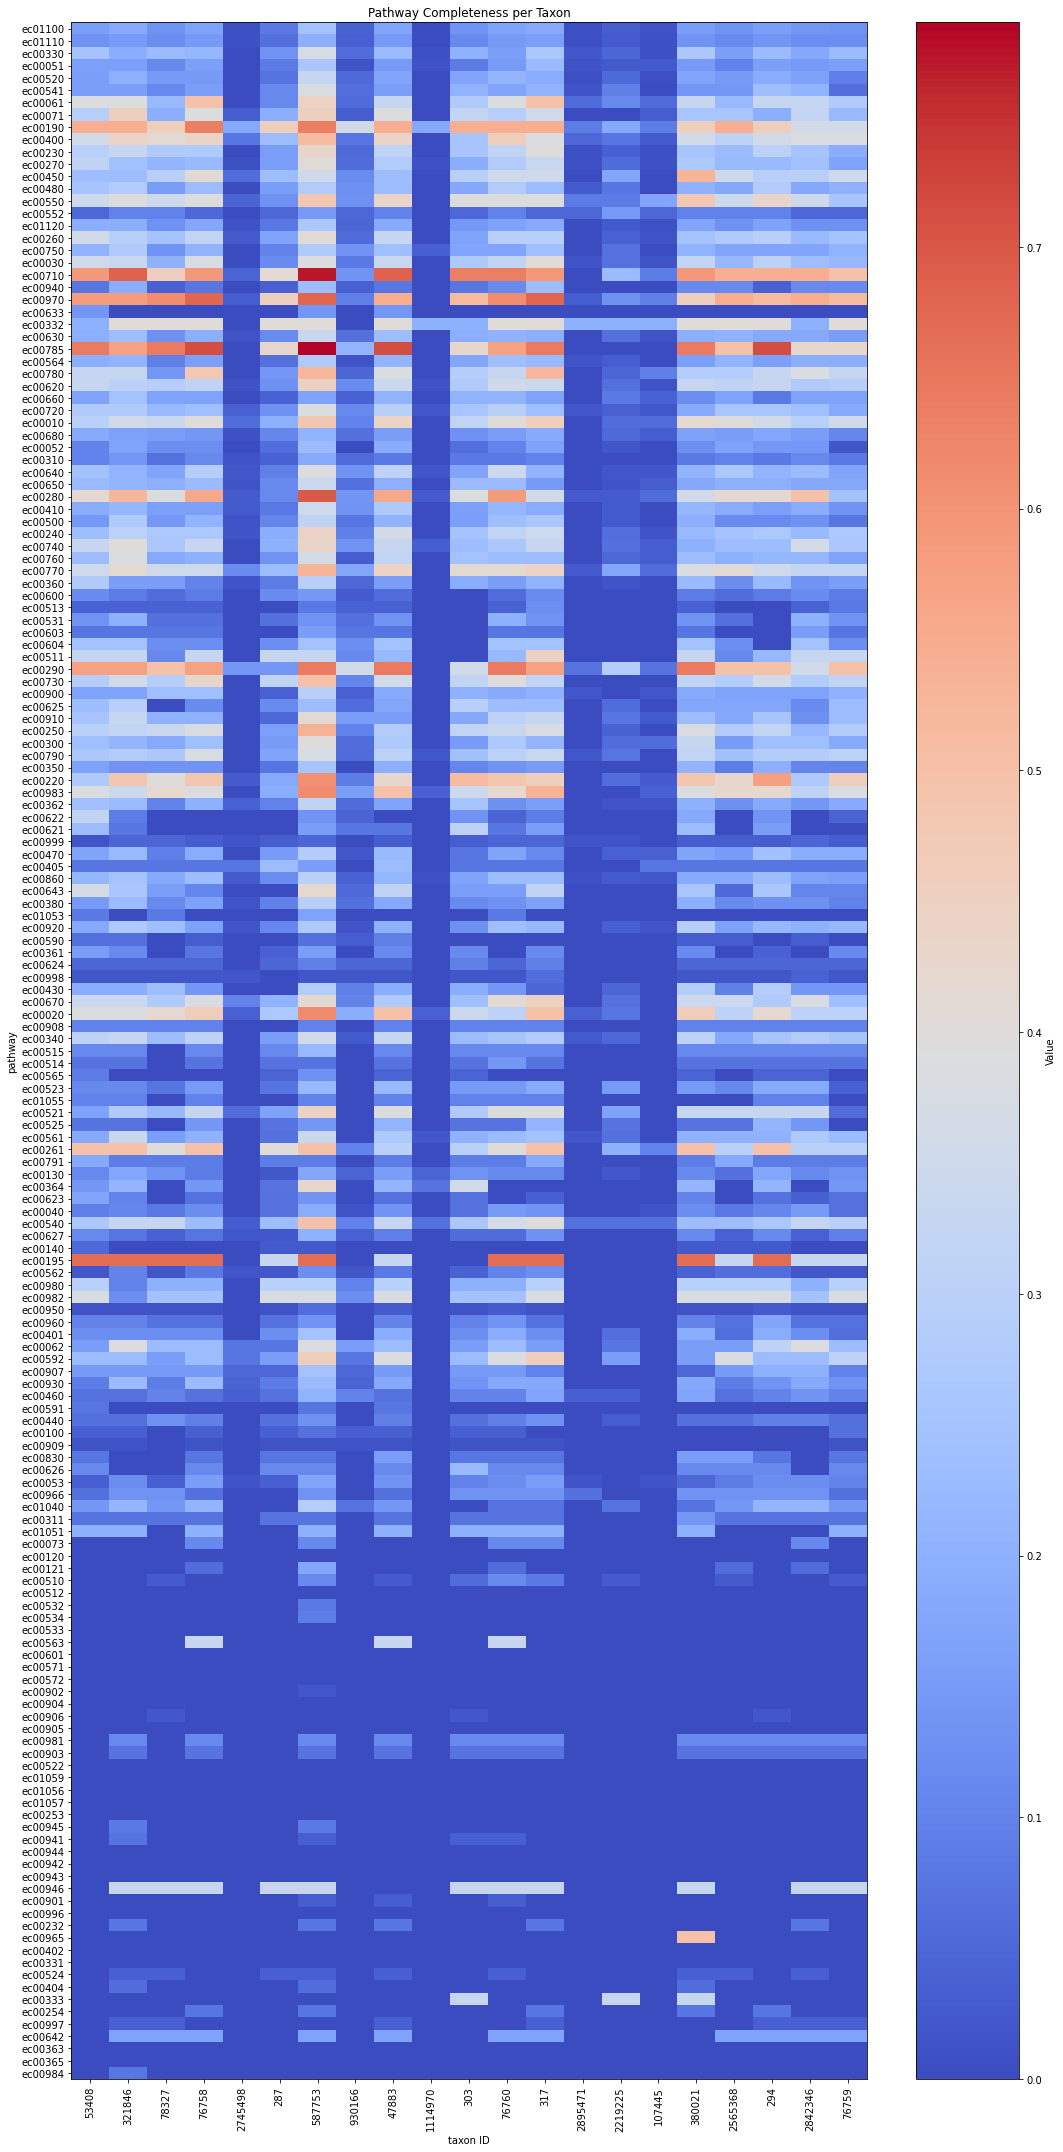

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv("all_EC_pathway_completeness.csv")

# Extract pathway names and deepECs
pathways = df['pathway']
deepECs = df.columns[1:]

# Convert data to a numpy array
data = df.values[:, 1:].astype(float)

# Create a heatmap
plt.figure(figsize=(15, 30))
plt.imshow(data, cmap='coolwarm', aspect='auto')

# Set labels for axes
plt.xticks(np.arange(len(deepECs)), deepECs, rotation=90)
plt.yticks(np.arange(len(pathways)), pathways)

# Add color bar
plt.colorbar(label='Value')

# Show plot
plt.title('Pathway Completeness per Taxon')
plt.xlabel('taxon ID')
plt.ylabel('pathway')
plt.tight_layout()
plt.show()


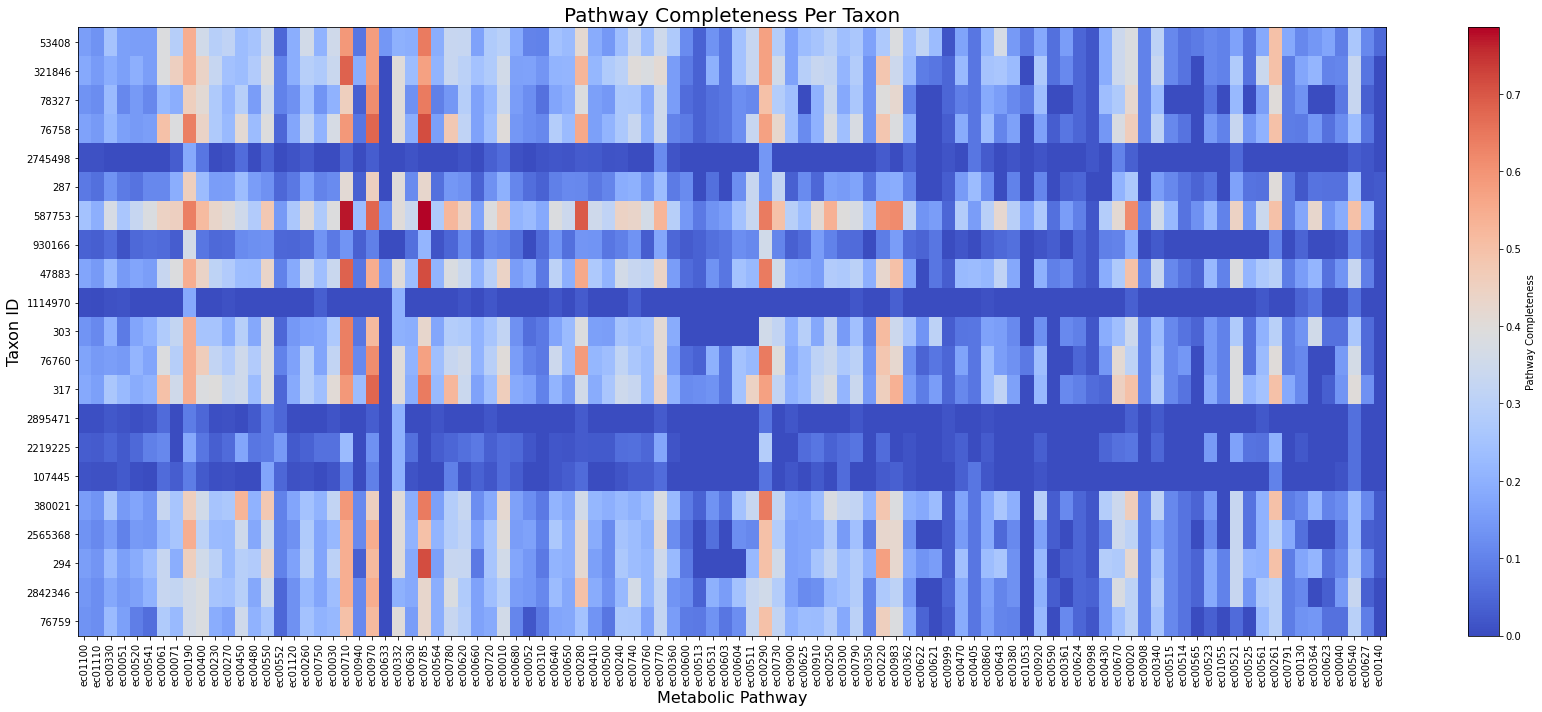

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the modified CSV file
df = pd.read_csv("all_EC_pathway_completeness.csv")
df = df[0:100]

# Extract pathway names and deepECs
pathways = df.iloc[:, 0].values
deepECs = df.columns[1:]

# Convert data to a numpy array and transpose it
data = df.iloc[:, 1:].values.astype(float)
data = data.T

deepECs = [s.replace("deepEC_", "") for s in deepECs]
# Create a heatmap
plt.figure(figsize=(24, 10))
plt.imshow(data, cmap='coolwarm', aspect='auto')

# Set labels for axes
plt.yticks(np.arange(len(deepECs)), deepECs)
plt.xticks(np.arange(len(pathways)), pathways, rotation=90)

# Add color bar
plt.colorbar(label='Pathway Completeness')

# Show plot
plt.title('Pathway Completeness Per Taxon', fontsize=20)
plt.xlabel('Metabolic Pathway', fontsize=16)
plt.ylabel('Taxon ID', fontsize=16)
plt.tight_layout()
plt.savefig("pathway_completeness.png")  # Change the filename and format as needed
plt.show()


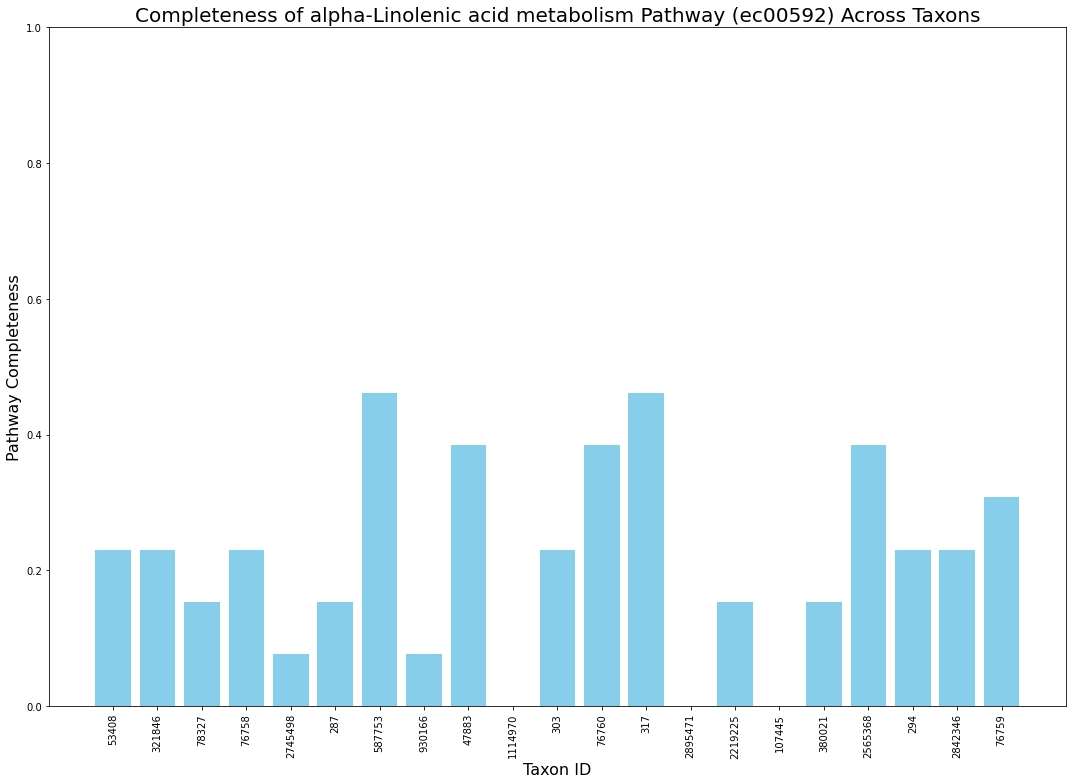

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv("all_EC_pathway_completeness.csv")

# Choose the pathway for which you want to plot completeness
chosen_pathway = "ec00261"  # Change this to your desired pathway

# Extract the completeness values for the chosen pathway
pathway_completeness = df[df['pathway'] == chosen_pathway].iloc[:, 1:].squeeze()

# Get the taxon labels (deepECs)
taxons = pathway_completeness.index

# Create the bar plot
plt.figure(figsize=(15, 11))
plt.bar(taxons, pathway_completeness, color='skyblue')

# Add labels and title
name = "Monobactam biosynthesis"
plt.title(f'Completeness of {name} Pathway ({chosen_pathway}) Across Taxons', fontsize=20)
plt.xlabel('Taxon ID', fontsize=16)
plt.ylabel('Pathway Completeness', fontsize=16)
plt.ylim(0, 1.0)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()

plt.savefig(f"{chosen_pathway}_completeness.png")
# Show the plot
plt.show()
